<div style="display: inline-block;">
<img style="float:left;margin-right:50px;" src="ecas_logo.png" alt="ECAS Logo" width="400">
</div>
<div style="display: inline-block;">
<img style="float:right;" src="onedata_logo.png" alt="OneData Logo" width="400">
</div>

# Training with ECAS: computation of a climate indicator from a shared data collection

This notebook explains how to execute a sample climate indicator exploiting the features provided by the **ECAS** environment (in particular, those provided by the *Ophidia Framework*) and accessing input datafiles shared on the **OneData** platform.

The *ENES Climate Analytics Service* (ECAS) is one of the *EOSC-Hub Thematic Services*. It builds on top of the Ophidia big data analytics framework with additional components and services from the INDIGO-DataCloud software stack, EUDAT and EGI e-infrastructures.

*OneData* is a global data management system, providing easy access to distributed storage resources, supporting wide range of use cases from personal data management to data-intensive scientific computations.

The goal of this training is to implement a real indicator from the *extreme climate indices* set directly on a shared and geographically distributed data collection exposed in the *Federated Data Archive* in a transparent way, without unnecessary data movement.

This set comprises 27 indices based on daily temperatures or daily precipitation amount, defined with the purpose to analyze extreme events. In this training we are going to compute the *Summer Days index*: starting from the daily maximum temperature (2096-2100), the Summer Days index is the annual count of days where TX (daily maximum temperature) > 25°C.
The full list of indices is provided here: [http://etccdi.pacificclimate.org/list_27_indices.shtml](http://etccdi.pacificclimate.org/list_27_indices.shtml).

The training session will be completely carried out in this Jupyter Notebook using python code and the set of modules and libraries available in the ECASlab; in particular, the calculation of the climate index will exploit a global data repository provided by the modelling groups and backed by computing centers and storage providers worldwide.

Before starting the actual implementation of the indicator, let's understand the main features of Onedata, how data is organized and what are the key concepts behind its implementation.
For more details, please visit the official website: https://onedata.org/#/home

## 1. Getting started with Onedata

**Onedata** is a global data access solution for eScience. It allows users to:
- access data in a dropbox-like fashion regardless of its location
- perform heavy computations on huge datasets
- publish and share results with public or closed communities

The platform consists of 3 main components:
- *Spaces*: distributed virtual volumes, where users can organize their data
- *Providers*: entities who support user spaces with actual storage resources exposed via Oneprovider services
- *Zones*: federations of providers, which enable creation of closed or interconnected communities, managed by Onezone services.

The following picture shows a view of a geographically distributed OneData space supported by some providers and used in ECASLab.

<img src="Federated_Data_Archive.png" alt="OneZone interface" width="800"> 

## 2. OneData integration in ECAS

In the context of ECAS, an existing (read-only) data collection, provided for instance by a modelling group, is exposed via dedicated OneData services and made available in the ECASLab environment.
Specifically, each user can easily access and process data, which are made available in its own workspace.

More in details, when you log in to JupyterHub, the following data directories are available in you workspace:

- **/data:** input data required for the workflows/notebooks locally available in the ECAS environment
- **/onedata:** Federated Data Archive exposed via OneData    

Under the **/onedata/repository** directory, you can find the shared repository, named **ECAS_space**, containing all data that you can use to run your notebooks. 
The *ECAS_space* is supported by multiple geographically distributed storage providers, but Onedata unifies access to these storage resources automatically. 

## 3. Calculate the Summer Days index

Now that you have an understanding of the data organizaton, you're ready to calculate the Summer Days index using the NetCDF files provided in the *ECAS_space* repository.

First of all, connect to the remote ECAS instance

In [1]:
from PyOphidia import cube
cube.Cube.setclient(read_env=True)

Current cdd is /home/fantonio/PS4
Current session is https://ophidialab.cmcc.it/ophidia/sessions/299263995621886985641522057630934104/experiment
Current cwd is /
The last produced cube is https://ophidialab.cmcc.it/ophidia/2247/285396


List the files available into the shared data collection

In [2]:
cube.Cube.fs(command='ls', dpath='/onedata/repository/ECAS_space/*.nc', display=True)

/onedata/repository/ECAS_space/*.nc
-----------------------------------
+===+========================================================+
| T | OBJECT                                                 |
|   |                                                        |
+===+========================================================+
| f | tasmax_day_CMCC-CESM_rcp85_r1i1p1_20960101-21001231.nc |
|---|--------------------------------------------------------|
| f | tos_O1_2001-2002.nc                                    |
+===+========================================================+
Execution time: 0.11 seconds


Import the *tasmax* source file (minimum temperature °K) from the repository into an Ophidia datacube

In [3]:
maxtemp = cube.Cube(src_path='/onedata/repository/ECAS_space/tasmax_day_CMCC-CESM_rcp85_r1i1p1_20960101-21001231.nc',
    measure='tasmax',
    import_metadata='yes',
    imp_dim='time',
    imp_concept_level='d', vocabulary='CF',hierarchy='oph_base|oph_base|oph_time',
    ncores=4,
    description='Max Temps'
    )

New cube is https://ophidialab.cmcc.it/ophidia/2291/285645


Identify the summer days

In [4]:
summerdays = maxtemp.apply(
    query="oph_predicate('oph_float','oph_int',measure,'x-298.15','>0','1','0')"
)

Count the number of summer days

In [5]:
count = summerdays.reduce2(
    operation='sum',
    dim='time',
    concept_level='y',
)

Finally plot the indicator

In [6]:
firstyear = count.subset(subset_filter=1, subset_dims='time')

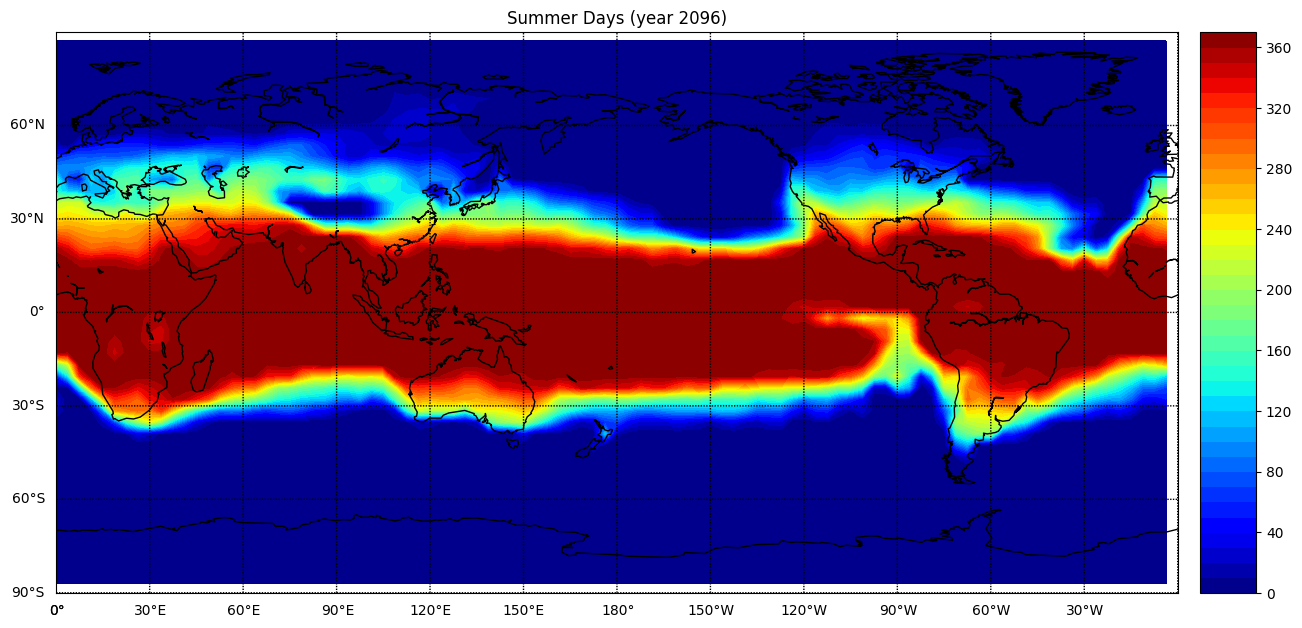

In [7]:
data = firstyear.export_array(show_time='yes')
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap, cm
import numpy as np

lat = data['dimension'][0]['values'][:]
lon = data['dimension'][1]['values'][:]
var = data['measure'][0]['values'][:]
var = np.reshape(var, (len(lat), len(lon)))

fig = plt.figure(figsize=(15, 15), dpi=100)
ax  = fig.add_axes([0.1,0.1,0.8,0.8])

map = Basemap(projection='cyl',llcrnrlat= -90,urcrnrlat= 90, llcrnrlon=0,urcrnrlon=360, resolution='c')

map.drawcoastlines()
map.drawparallels(np.arange( -90, 90,30),labels=[1,0,0,0])
map.drawmeridians(np.arange(-180,180,30),labels=[0,0,0,1])

x, y = map(*np.meshgrid(lon,lat))

clevs = np.arange(0,371,10)

cnplot = map.contourf(x,y,var,clevs,cmap=plt.cm.jet)
cbar = map.colorbar(cnplot,location='right')

plt.title('Summer Days (year 2096)')
plt.show()

## 4. Final remarks

Congrats! You've completed this training regarding some basics operations that can be performed within the ECASlab and you should now be able to:

* use the PyOphidia module to access a OneData repository;
* perform the computation of climate index over a shared data collection.

If you want to clear your user space before running other notebooks, run the following commands:

In [8]:
cube.Cube.client.submit("oph_delete cube=[container=tasmax_day_CMCC-CESM_rcp85_r1i1p1_20960101-21001231.nc]")
cube.Cube.deletecontainer(container='tasmax_day_CMCC-CESM_rcp85_r1i1p1_20960101-21001231.nc')

## References

1. [OneData website](https://onedata.org/#/home)
2. [EOSC-Hub project website](https://www.eosc-hub.eu)
3. [PyOphidia library](https://github.com/OphidiaBigData/PyOphidia)